In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.2.0
sys.version_info(major=3, minor=6, micro=9, releaselevel='final', serial=0)
matplotlib 3.3.4
numpy 1.19.5
pandas 1.1.5
sklearn 0.24.2
tensorflow 2.2.0
tensorflow.keras 2.3.0-tf


In [2]:
from sklearn import datasets
import tarfile
data_home = datasets.get_data_home()
archive_path = os.path.join(data_home, 'cal_housing.tgz')
with tarfile.open(mode="r:gz", name=archive_path) as f:
     cal_housing = np.loadtxt(
         f.extractfile("CaliforniaHousing/cal_housing.data"), delimiter=","
     )
     # Columns are not in the same order compared to the previous
     # URL resource on lib.stat.cmu.edu
     columns_index = [8, 7, 2, 3, 4, 5, 6, 1, 0]
     cal_housing = cal_housing[:, columns_index]
       
feature_names = [
    "MedInc",
    "HouseAge",
    "AveRooms",
    "AveBedrms",
    "Population",
    "AveOccup",
    "Latitude",
    "Longitude",
]

target, data = cal_housing[:, 0], cal_housing[:, 1:]

# avg rooms = total rooms / households
data[:, 2] /= data[:, 5]

# avg bed rooms = total bed rooms / households
data[:, 3] /= data[:, 5]

# avg occupancy = population / households
data[:, 5] = data[:, 4] / data[:, 5]

# target in units of 100,000
target = target / 100000.0


In [3]:
from sklearn.model_selection import train_test_split

x_train_all, x_test, y_train_all, y_test = train_test_split(
    data,target, random_state = 7)
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_all, y_train_all, random_state = 11)
print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)


(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)


In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)
x_test_scaled = scaler.transform(x_test)

In [5]:
# 多输入，输入不再是同一个，wind和deep的输入不一样
input_wide = keras.layers.Input(shape=[5])
print(input_wide)
print(type(input_wide))
input_deep = keras.layers.Input(shape=[6])
print(input_deep)
print(type(input_deep))
#只是deep的输入是input_deep，之前deep的输入就是input
hidden1 = keras.layers.Dense(30, activation='relu')(input_deep)
hidden2 = keras.layers.Dense(30, activation='relu')(hidden1)
concat = keras.layers.concatenate([input_wide, hidden2])
output = keras.layers.Dense(1)(concat)
#这里是多输入
model = keras.models.Model(inputs = [input_wide, input_deep],
                           outputs = [output])
        

model.compile(loss="mean_squared_error", optimizer="sgd")
callbacks = [keras.callbacks.EarlyStopping(
    patience=5, min_delta=1e-3)]
model.summary()

Tensor("input_1:0", shape=(None, 5), dtype=float32)
<class 'tensorflow.python.framework.ops.Tensor'>
Tensor("input_2:0", shape=(None, 6), dtype=float32)
<class 'tensorflow.python.framework.ops.Tensor'>
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 30)           210         input_2[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________

In [6]:
#wide选的是前面5列，deep选的是后面6列
x_train_scaled_wide = x_train_scaled[:, :5]
x_train_scaled_deep = x_train_scaled[:, 2:]
x_valid_scaled_wide = x_valid_scaled[:, :5]
x_valid_scaled_deep = x_valid_scaled[:, 2:]
x_test_scaled_wide = x_test_scaled[:, :5]
x_test_scaled_deep = x_test_scaled[:, 2:]
print(x_train_scaled_wide[:5])
print(x_train_scaled_deep[:5])
x_train_scaled_wide=x_train_scaled_wide[:10000]
x_train_scaled_deep=x_train_scaled_deep[:10000]
y_train=y_train[:10000]

[[ 0.80154431  0.27216142 -0.11624393 -0.20231151 -0.54305157]
 [-0.29807281  0.35226166 -0.10920508 -0.25055521 -0.03406402]
 [-0.03058829 -0.92934213  0.25962148 -0.00601274 -0.50040912]
 [ 1.90638325  0.51246213  0.4475828  -0.27672178 -0.63105833]
 [ 3.88017387 -0.92934213  1.29029867 -0.17269133 -0.22550141]]
[[-0.11624393 -0.20231151 -0.54305157 -0.02103962 -0.58976206 -0.08241846]
 [-0.10920508 -0.25055521 -0.03406402 -0.006034    1.08055484 -1.06113817]
 [ 0.25962148 -0.00601274 -0.50040912 -0.03077987  1.59844639 -1.81515182]
 [ 0.4475828  -0.27672178 -0.63105833 -0.07081147 -0.7064043   0.74649722]
 [ 1.29029867 -0.17269133 -0.22550141  0.0514101  -0.84637499  0.88631432]]


In [7]:
history = model.fit([x_train_scaled_wide, x_train_scaled_deep],
                    y_train,
                    validation_data = (
                        [x_valid_scaled_wide, x_valid_scaled_deep],
                        y_valid),
                    epochs = 100,
                    callbacks = callbacks)

Epoch 1/100
313/313 [==============================] - 1s 5ms/step - loss: 0.9392 - val_loss: 0.5640
Epoch 2/100
313/313 [==============================] - 1s 4ms/step - loss: 0.4828 - val_loss: 0.5190
Epoch 3/100
313/313 [==============================] - 1s 4ms/step - loss: 0.4593 - val_loss: 0.4688
Epoch 4/100
313/313 [==============================] - 1s 3ms/step - loss: 0.4392 - val_loss: 0.4656
Epoch 5/100
313/313 [==============================] - 1s 4ms/step - loss: 0.4213 - val_loss: 0.4492
Epoch 6/100
313/313 [==============================] - 1s 3ms/step - loss: 0.4119 - val_loss: 0.4334
Epoch 7/100
313/313 [==============================] - 1s 3ms/step - loss: 0.4138 - val_loss: 0.4337
Epoch 8/100
313/313 [==============================] - 1s 3ms/step - loss: 0.4064 - val_loss: 0.4311
Epoch 9/100
313/313 [==============================] - 1s 3ms/step - loss: 0.3970 - val_loss: 0.7463
Epoch 10/100
313/313 [==============================] - 1s 3ms/step - loss: 0.4094 - val_lo

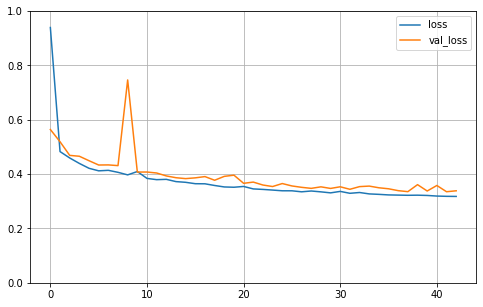

In [8]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()
plot_learning_curves(history)

In [9]:
#可以看出比之前效果改进很多
model.evaluate([x_test_scaled_wide, x_test_scaled_deep], y_test, verbose=0)

0.3330821096897125